In [1]:
import zipfile

# Path to the uploaded zip file
zip_path = '/content/Teeth DataSet.zip'  # Replace with the name of your uploaded file

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/unzipped_folder')  # Extract to a folder named 'unzipped_folder'

In [2]:
import os

# List files in the unzipped folder
unzipped_folder = '/content/unzipped_folder'
print(os.listdir(unzipped_folder))

['Teeth_Dataset']


In [3]:
dataset_path = '/content/unzipped_folder/Teeth_Dataset'

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications, models, optimizers, callbacks
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
img_size=(224, 224)
batch_size=32
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, 'Training'),
    validation_split=0.2,
    subset="training",
    seed=55,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 3087 files belonging to 7 classes.
Using 2470 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(dataset_path, 'Validation'),
  validation_split=0.2,
  subset="validation",
  seed=55,
  image_size=img_size,
  batch_size=batch_size,
  label_mode='int')

Found 1028 files belonging to 7 classes.
Using 205 files for validation.


In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(dataset_path, 'Testing'),
  seed=55,
  image_size=img_size,
  batch_size=batch_size,
  label_mode='int')

Found 1508 files belonging to 10 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


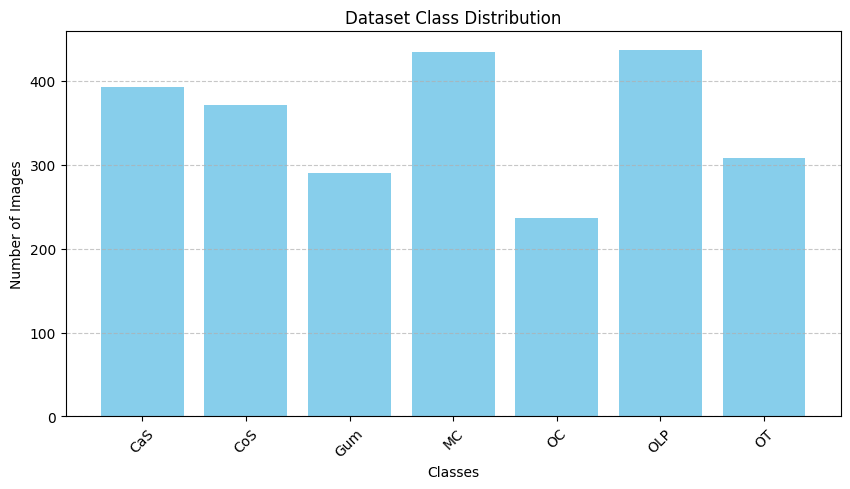

In [ ]:
import matplotlib.pyplot as plt
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Sort the classes and their counts
sorted_classes = list(class_counts.keys())
sorted_counts = list(class_counts.values())

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts, color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Dataset Class Distribution")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

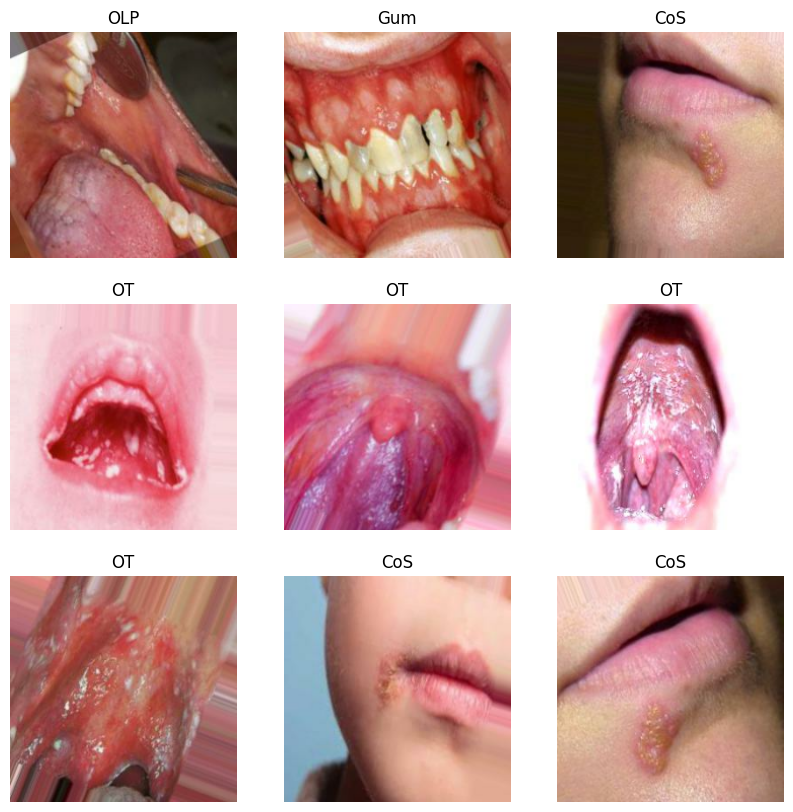

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [10]:
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(224,244, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
from tensorflow.keras.applications import DenseNet121

In [14]:
#base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),  # Ensure correct dimensions
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model layers
for layer in base_model.layers[-20:]:  # Unfreeze last 50 layers
    layer.trainable = True

In [15]:
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(7, activation='softmax')
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau  # Import ReduceLROnPlateau


early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3,min_lr=1e-6,  verbose=1)

In [20]:
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping, checkpoint,reduce_lr])

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 511s 6s/step - accuracy: 0.3446 - loss: 1.8398 - val_accuracy: 0.5610 - val_loss: 1.1244 - learning_rate: 0.0010
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 478s 6s/step - accuracy: 0.5777 - loss: 1.1233 - val_accuracy: 0.7268 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 468s 6s/step - accuracy: 0.7370 - loss: 0.7633 - val_accuracy: 0.7902 - val_loss: 0.7057 - learning_rate: 0.0010
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 491s 6s/step - accuracy: 0.7968 - loss: 0.5865 - val_accuracy: 0.8634 - val_loss: 0.4005 - learning_rate: 0.0010
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 464s 6s/step - accuracy: 0.8420 - loss: 0.4462 - val_accuracy: 0.8976 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 477s 6s/step - accuracy: 0.8931 - loss: 0.3405 - val_accuracy: 0.9024 - val_loss: 0.2799 - learning_rate: 0.0010
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 459s 6s/step - accuracy: 0.8920 - loss: 0.3238 - val_acc

Text(0.5, 1.0, 'Training & Validation Accuracy')

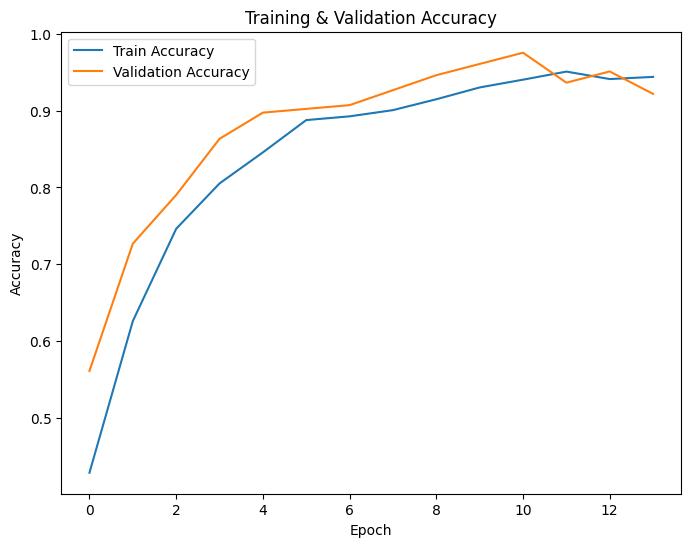

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

In [29]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(dataset_path, 'Testing'),
  seed=123,
  image_size=(224,224),
  batch_size=32
)

# Examine and potentially fix the labels before normalization
for images, labels in test_ds.take(1):
    print("Original labels:", labels.numpy())  # Check the labels in your test_ds
    # Check for labels outside the expected range (0 to 6) and potentially remap
    invalid_labels = np.where(labels.numpy() >= 7)
    if len(invalid_labels[0]) > 0:
        print("Found invalid labels:", invalid_labels[0])

        labels = tf.where(labels >= 7, 0, labels) # Adjust this for the specific logic you need

        test_ds = test_ds.map(lambda images, original_labels: (images, tf.where(original_labels >= 7, 0, original_labels)))

# Apply normalization after checking and potentially fixing labels
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 1508 files belonging to 10 classes.
Original labels: [1 3 5 4 1 9 6 9 8 2 8 6 5 0 5 9 4 6 2 2 6 7 0 4 3 3 5 6 7 8 9 3]
Found invalid labels: [ 5  7  8 10 15 21 28 29 30]


48/48 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step
Sample 1:
  Predicted class: Gum
  Confidence score: 69.97%


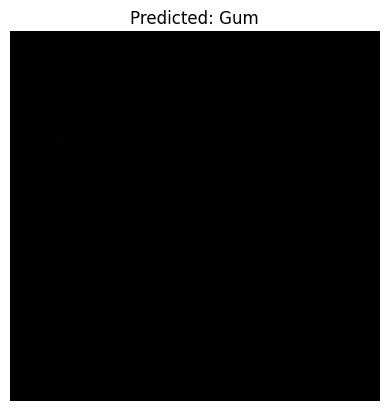

Sample 2:
  Predicted class: OT
  Confidence score: 100.00%


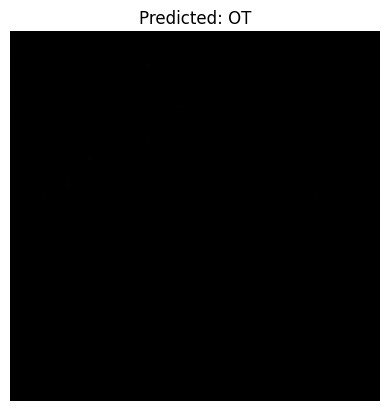

Sample 3:
  Predicted class: Gum
  Confidence score: 78.09%


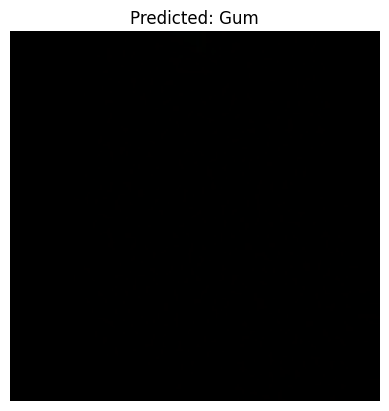

Sample 4:
  Predicted class: CaS
  Confidence score: 96.33%


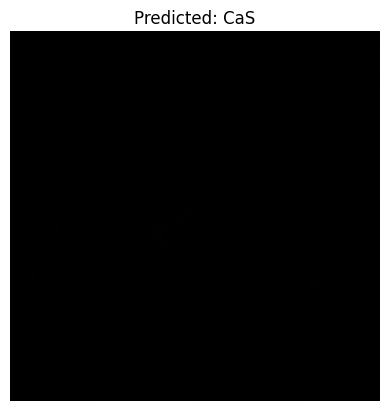

Sample 5:
  Predicted class: Gum
  Confidence score: 85.90%


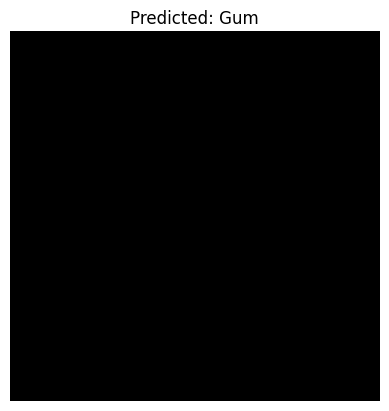

Sample 6:
  Predicted class: OLP
  Confidence score: 94.89%


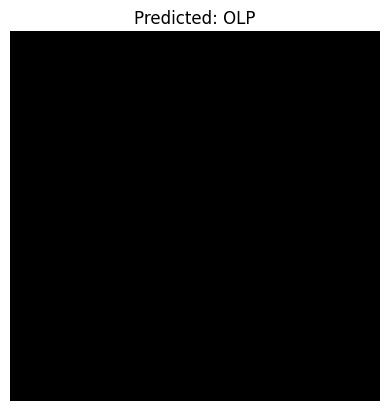

Sample 7:
  Predicted class: MC
  Confidence score: 88.17%


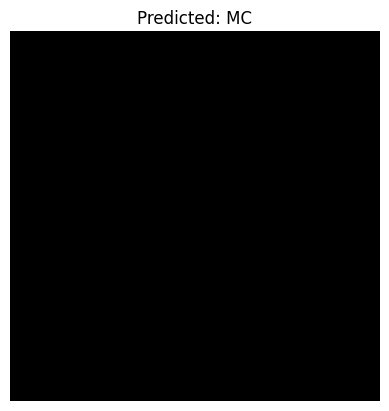

Sample 8:
  Predicted class: Gum
  Confidence score: 99.75%


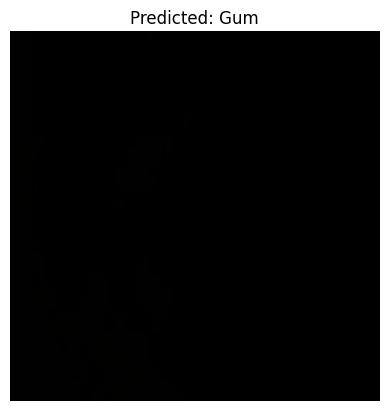

Sample 9:
  Predicted class: Gum
  Confidence score: 40.82%


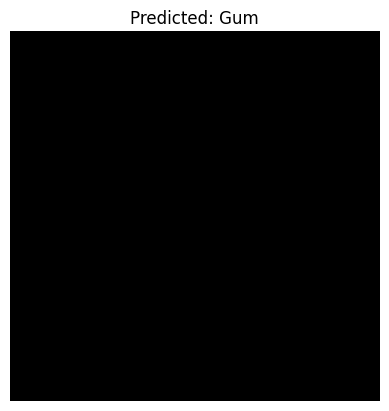

Sample 10:
  Predicted class: CaS
  Confidence score: 100.00%


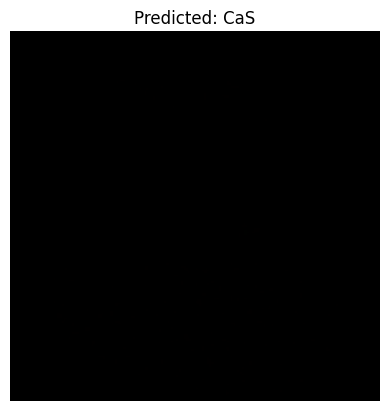

In [31]:
predictions = model.predict(test_ds)

image_batch, labels_batch = next(iter(test_ds))

num_samples = 10

for i in range(num_samples):
    prediction = predictions[i]

    predicted_class_index = np.argmax(prediction)

    predicted_class_name = class_names[predicted_class_index]

    confidence_score = 100 * np.max(prediction)

    print("Sample {}:".format(i + 1))
    print("  Predicted class: {}".format(predicted_class_name))
    print("  Confidence score: {:.2f}%".format(confidence_score))

    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title("Predicted: {}".format(predicted_class_name))
    plt.axis("off")
    plt.show()

In [33]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


In [64]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
# Load the trained model
model = tf.keras.models.load_model("/content/best_model.keras")

# Define class labels (update based on your dataset)
class_names = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

st.title("Image Classification with Fine-Tuned DenseNet")

uploaded_file = st.file_uploader("Upload an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess the image
    img = image.resize((224, 224))
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    st.write(f"### Prediction: {predicted_class}")
    st.write(f"Confidence: {confidence:.2f}")

Overwriting app.py


In [67]:
!npm install -g localtunnel
!streamlit run app.py &
!lt --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
changed 22 packages in 3s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.231.105.181:8501

  Stopping...
your url is: https://fine-cloths-vanish.loca.lt
^C
